In [19]:
import random
import pickle
import numpy as np
from skimage.measure import label
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from skimage.filters import threshold_otsu
from scipy.ndimage.filters import convolve
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

In [2]:
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)

In [3]:
data = pickle.load(open('../../../../../get_data/collman15_downsample.pkl', 'rb'))
print(data.keys())

dict_keys(['annotation', 'VGluT1_647', 'GAD647', 'Synapsin647', 'PSD95_488', 'NR1594', 'GABA488', 'MBP488', 'GS594', 'gephyrin594'])


In [4]:
def compute_convolutional_cov(vol1, vol2, kernel_shape):
    vol1 = (vol1 - np.mean(vol1))/np.std(vol1)
    vol2 = (vol2 - np.mean(vol2))/np.std(vol2)
    mu_kernel = np.ones(kernel_shape)/float(np.sum(np.ones(kernel_shape)))
    e1 = convolve(vol1, mu_kernel)
    e2 = convolve(vol2, mu_kernel)

    e12 = convolve(np.log(np.exp(vol1)+np.exp(vol2)), mu_kernel)

    cov = e12 - np.log(np.exp(e1) + np.exp(e2))

    return cov

In [5]:
label_annot = label(data['annotation'] > 0)
ccov_vol = compute_convolutional_cov(data['PSD95_488'],
                                     data['Synapsin647'],
                                    (2, 3, 3))
feature_data = [data[elem]\
                for elem in ['PSD95_488', 'Synapsin647', 'NR1594']]
feature_data.append(ccov_vol)
feature_data = np.stack(feature_data)
print(feature_data.shape)

(4, 27, 174, 243)


In [6]:
def get_train_idx_list(ratio):
    synapses = np.unique(label_annot)
    slice_max = int(ratio * len(synapses))
    random.shuffle(synapses)
    train_set = synapses[:slice_max]
    return train_set

In [7]:
def make_positive_feature_vector(train_idx, r):
    centroid = [int(np.mean(elem))\
                for elem in np.where(label_annot == train_idx)]
    minz = max(int(centroid[0]-r/2), 0)
    maxz = min(int(centroid[0]+r/2), 26)
    
    miny = max(centroid[1]-r, 0)
    maxy = min(centroid[1]+r, 173)
    
    minx = max(centroid[2]-r, 0)
    maxx = min(centroid[2]+r, 242)
    
    cutout = feature_data[:, minz:maxz, miny:maxy, minx:maxx]
    feature_vector = [np.mean(cutout[i]) for i in range(feature_data.shape[0])]
    return feature_vector

In [8]:
def propose_negative_coordinates(r):
    centroid = [int(np.random.random() * (elem-1))\
                          for elem in feature_data.shape[1:]]
    
    minz = max(int(centroid[0]-r/2), 0)
    maxz = min(int(centroid[0]+r/2), 26)
    
    miny = max(centroid[1]-r, 0)
    maxy = min(centroid[1]+r, 173)
    
    minx = max(centroid[2]-r, 0)
    maxx = min(centroid[2]+r, 242)
   
    return minz, maxz, miny, maxy, minx, maxx
    
    
def make_negative_feature_vector(r):
    minz, maxz, miny, maxy, minx, maxx = propose_negative_coordinates(r)
    while np.max(label_annot[minz:maxz, miny:maxy, minx:maxx]) > 0:
        minz, maxz, miny, maxy, minx, maxx = propose_negative_coordinates(r)
    
    cutout = feature_data[:, minz:maxz, miny:maxy, minx:maxx]
    feature_vector = [np.mean(cutout[i]) for i in range(feature_data.shape[0])]
    return feature_vector

In [9]:
def run_lda_sim(train_ratio, radius):
    #get random data split
    train_idx_list = get_train_idx_list(train_ratio)
    train_positives = [make_positive_feature_vector(train_idx, radius)\
                       for train_idx in train_idx_list]
    train_negatives = [make_negative_feature_vector(radius)\
                       for _ in train_positives]
    
    train_feature_vectors = train_positives + train_negatives
    train_labels = [1 for _ in train_positives] + [0 for _ in train_negatives]
    
    #train model
    lda_model = LDA()
    lda_model.fit(train_feature_vectors, train_labels)
    
    #test model
    test_positive_idx_list = [elem\
                              for elem in np.unique(label_annot)\
                              if not elem in train_idx_list]
    
    test_positives = [make_positive_feature_vector(elem, radius)\
                      for elem in test_positive_idx_list]
    
    test_negatives = [make_negative_feature_vector(radius)\
                      for _ in train_positives]
    
    positive_predictions = lda_model.predict(test_positives)
    negative_predictions = lda_model.predict(test_negatives)
    
    #compute precision and recall
    rec = np.sum(positive_predictions)/len(test_positives)
    prec = np.sum(positive_predictions)/(np.sum(positive_predictions) + np.sum(negative_predictions))
    
    return prec, rec, len(train_feature_vectors)

In [10]:
def run_qda_sim(train_ratio, radius):
    #get random data split
    train_idx_list = get_train_idx_list(train_ratio)
    train_positives = [make_positive_feature_vector(train_idx, radius)\
                       for train_idx in train_idx_list]
    train_negatives = [make_negative_feature_vector(radius)\
                       for _ in train_positives]
    
    train_feature_vectors = train_positives + train_negatives
    train_labels = [1 for _ in train_positives] + [0 for _ in train_negatives]
    
    #train model
    lda_model = QDA()
    lda_model.fit(train_feature_vectors, train_labels)
    
    #test model
    test_positive_idx_list = [elem\
                              for elem in np.unique(label_annot)\
                              if not elem in train_idx_list]
    
    test_positives = [make_positive_feature_vector(elem, radius)\
                      for elem in test_positive_idx_list]
    
    test_negatives = [make_negative_feature_vector(radius)\
                      for _ in train_positives]
    
    positive_predictions = lda_model.predict(test_positives)
    negative_predictions = lda_model.predict(test_negatives)
    
    #compute precision and recall
    rec = np.sum(positive_predictions)/len(test_positives)
    prec = np.sum(positive_predictions)/(np.sum(positive_predictions) + np.sum(negative_predictions))
    
    return prec, rec, len(train_feature_vectors)

In [11]:
trial_summaries = []
for radius in list(range(2, 8)):
    prec_list = []
    rec_list = []
    for i in range(3):
        prec, rec, n = run_lda_sim(.66, radius)
        prec_list.append(prec)
        rec_list.append(rec)
    trial_summaries.append({'train_samples': n,
                            'radius': radius,
                            'ave_prec': np.mean(prec_list),
                            'var_prec': np.var(prec_list),
                            'ave_rec': np.mean(rec_list),
                            'var_rec': np.var(rec_list)})

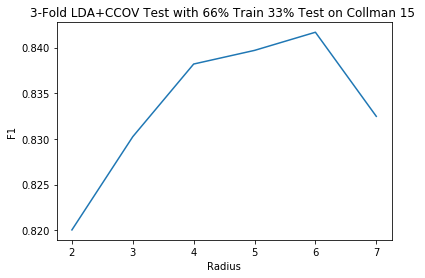

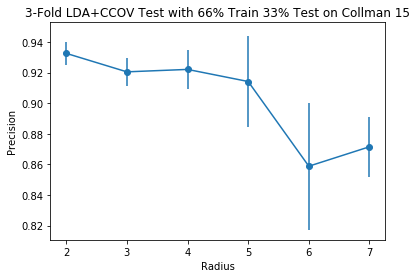

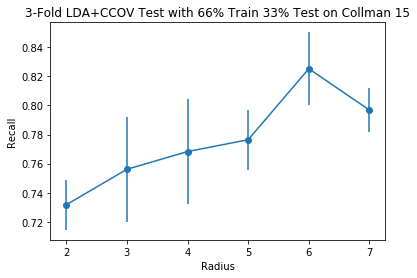

In [12]:
plt.figure()
xs = [elem['radius'] for elem in trial_summaries]
ys = [2*elem['ave_prec']*elem['ave_rec']/(elem['ave_prec']+elem['ave_rec']) for elem in trial_summaries]
plt.plot(xs, ys)
plt.title('3-Fold LDA+CCOV Test with 66% Train 33% Test on Collman 15 ')
plt.xlabel('Radius')
plt.ylabel('F1')
plt.show()

plt.figure()
xs = [elem['radius'] for elem in trial_summaries]
ys = [elem['ave_prec'] for elem in trial_summaries]
y_errs = [np.sqrt(elem['var_prec']) for elem in trial_summaries]
plt.scatter(xs, ys)
plt.errorbar(xs, ys, xerr=0, yerr=y_errs)
plt.title('3-Fold LDA+CCOV Test with 66% Train 33% Test on Collman 15')
plt.xlabel('Radius')
plt.ylabel('Precision')
plt.show()

plt.figure()
xs = [elem['radius'] for elem in trial_summaries]
ys = [elem['ave_rec'] for elem in trial_summaries]
y_errs = [np.sqrt(elem['var_rec']) for elem in trial_summaries]
plt.scatter(xs, ys)
plt.errorbar(xs, ys, xerr=0, yerr=y_errs)
plt.title('3-Fold LDA+CCOV Test with 66% Train 33% Test on Collman 15')
plt.xlabel('Radius')
plt.ylabel('Recall')
plt.show()


In [13]:
trial_summaries = []
for radius in list(range(2, 8)):
    prec_list = []
    rec_list = []
    for i in range(3):
        prec, rec, n = run_qda_sim(.66, radius)
        prec_list.append(prec)
        rec_list.append(rec)
    trial_summaries.append({'train_samples': n,
                            'radius': radius,
                            'ave_prec': np.mean(prec_list),
                            'var_prec': np.var(prec_list),
                            'ave_rec': np.mean(rec_list),
                            'var_rec': np.var(rec_list)})

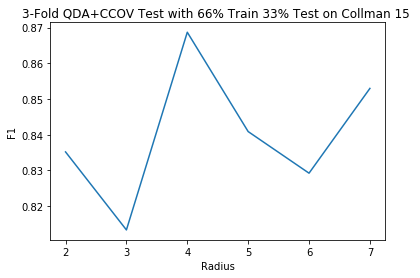

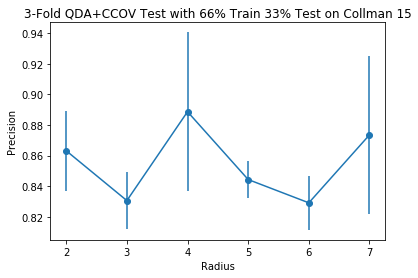

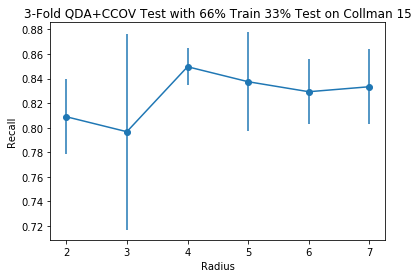

In [14]:
plt.figure()
xs = [elem['radius'] for elem in trial_summaries]
ys = [2*elem['ave_prec']*elem['ave_rec']/(elem['ave_prec']+elem['ave_rec']) for elem in trial_summaries]
plt.plot(xs, ys)
plt.title('3-Fold QDA+CCOV Test with 66% Train 33% Test on Collman 15 ')
plt.xlabel('Radius')
plt.ylabel('F1')
plt.show()

plt.figure()
xs = [elem['radius'] for elem in trial_summaries]
ys = [elem['ave_prec'] for elem in trial_summaries]
y_errs = [np.sqrt(elem['var_prec']) for elem in trial_summaries]
plt.scatter(xs, ys)
plt.errorbar(xs, ys, xerr=0, yerr=y_errs)
plt.title('3-Fold QDA+CCOV Test with 66% Train 33% Test on Collman 15')
plt.xlabel('Radius')
plt.ylabel('Precision')
plt.show()

plt.figure()
xs = [elem['radius'] for elem in trial_summaries]
ys = [elem['ave_rec'] for elem in trial_summaries]
y_errs = [np.sqrt(elem['var_rec']) for elem in trial_summaries]
plt.scatter(xs, ys)
plt.errorbar(xs, ys, xerr=0, yerr=y_errs)
plt.title('3-Fold QDA+CCOV Test with 66% Train 33% Test on Collman 15')
plt.xlabel('Radius')
plt.ylabel('Recall')
plt.show()


In [22]:
#get random data split
train_idx_list = get_train_idx_list(.66)
train_positives = [make_positive_feature_vector(train_idx, 2)\
                   for train_idx in train_idx_list]
train_negatives = [make_negative_feature_vector(2)\
                   for _ in train_positives]

train_feature_vectors = train_positives + train_negatives
train_labels = [1 for _ in train_positives] + [0 for _ in train_negatives]

#train models
lda_model = LDA()
lda_model.fit(train_feature_vectors, train_labels)

qda_model = QDA()
qda_model.fit(train_feature_vectors, train_labels)

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariance=False, store_covariances=None, tol=0.0001)

In [23]:
z = 10
lda_preds = np.zeros_like(label_annot[z])
qda_preds = np.zeros_like(label_annot[z])

for y in range(label_annot.shape[1]):
    for x in range(label_annot.shape[2]):
        centroid = [z, y, x]
        
        minz = max(centroid[0]-2, 0)
        maxz = min(centroid[0]+2, 26)

        miny = max(centroid[1]-2, 0)
        maxy = min(centroid[1]+2, 173)

        minx = max(centroid[2]-2, 0)
        maxx = min(centroid[2]+2, 242)

        cutout = feature_data[:, minz:maxz, miny:maxy, minx:maxx]
        feature_vector = np.array([np.mean(cutout[i]) for i in range(feature_data.shape[0])]).reshape(1, -1)
        
        lda_preds[centroid[1], centroid[2]] = lda_model.predict(feature_vector)[0]
        qda_preds[centroid[1], centroid[2]] = qda_model.predict(feature_vector)[0]

In [26]:
def make_overlap_img(a, b):
    bin_a = a > threshold_otsu(a)
    bin_b = b > threshold_otsu(a)
    rgb_both = np.moveaxis(np.stack([bin_a, bin_b, np.zeros_like(bin_a)]), 0, -1)
    rgb_both = rgb_both.astype(float)
    return rgb_both

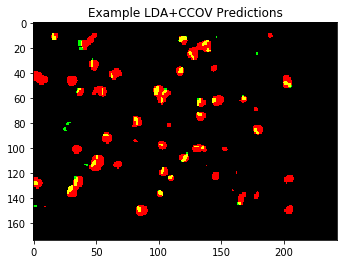

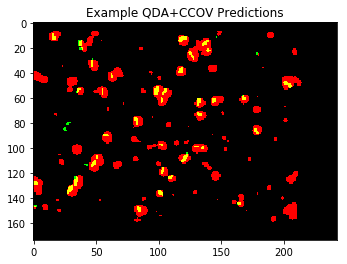

In [28]:
plt.figure()
plt.title('Example LDA+CCOV Predictions')
plt.imshow(make_overlap_img(lda_preds, label_annot[z] > 0))
plt.show()

plt.figure()
plt.title('Example QDA+CCOV Predictions')
plt.imshow(make_overlap_img(qda_preds, label_annot[z] > 0))
plt.show()